<a href="https://colab.research.google.com/github/YuliannaG/DataScience9/blob/main/HW9_tensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Создание нейронной сети

В этом задании мы создадим полносвязную нейронную сеть используя при этом низкоуровневые механизмы tensorflow.

Архитектутра нейросети представлена на следующем рисунке. Как видите, в ней имеется один входной слой, два скрытых, а так же выходной слой. В качестве активационной функции в скрытых слоях будет использоваться сигмоида. На выходном слое мы используем softmax.

Часть кода по созданию сети уже написана, от вас требуется заполнить пропуски в указанных местах.

## Архитектура нейронной сети

<img src="http://cs231n.github.io/assets/nn1/neural_net2.jpeg" alt="nn" style="width: 400px;"/>


## О датасете MNIST

Данную нейросеть мы будем обучать на датасете MNIST. Этот датасет представляет собой большое количество изображений рукописных цифр размером $28 \times 28$ пикселей. Каждый пиксель принимает значение от 0 до 255.

Как и раньше датасет будет разеделен на обучающую и тестовую выборки. При этом мы выполним нормализацию всех изображений, чтобы значения пикселей находились в промежутке от 0 до 1, разделив яркость каждого пикселя на 255.

Кроме того, архитектура нейронной сети ожидает на вход вектор. В нашем же случае каждый объект выборки представляет собой матрицу. Что же делать? В этом задании мы "растянем" матрицу $28 \times 28$, получив при этом вектор, состоящей из 784 элементов.

![MNIST Dataset](https://www.researchgate.net/profile/Steven-Young-5/publication/306056875/figure/fig1/AS:393921575309346@1470929630835/Example-images-from-the-MNIST-dataset.png)

Больше информации о датасете можно найти [здесь](http://yann.lecun.com/exdb/mnist/).

In [41]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [42]:
num_classes = 10 # общее количество классов, в нашем случае это цифры от 0 до 9
num_features = 784 # количество атрибутов входного вектора 28 * 28 = 784

learning_rate = 0.001 # скорость обучения нейронной сети
training_steps = 3000 # максимальное число эпох
batch_size = 256 # пересчитывать веса сети мы будем не на всей выборке, а на ее случайном подможестве из batch_size элементов
display_step = 100 # каждые 100 итераций мы будем показывать текущее значение функции потерь и точности

n_hidden_1 = 128 # количество нейронов 1-го слоя
n_hidden_2 = 256 # количество нейронов 2-го слоя

In [43]:
from tensorflow.keras.datasets import mnist

# Загружаем датасет
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Преобразуем целочисленные пиксели к типа float32
x_train, x_test = np.array(x_train, np.float32), np.array(x_test, np.float32)

# Преобразуем матрицы размером 28x28 пикселей в вектор из 784 элементов
x_train, x_test = x_train.reshape([-1, num_features]), x_test.reshape([-1, num_features])

# Нормализуем значения пикселей
x_train, x_test = x_train / 255., x_test / 255.

# Перемешаем тренировочные данные
train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_data = train_data.repeat().shuffle(5000).batch(batch_size).prefetch(1)

In [44]:
# Создадим нейронную сеть

class DenseLayer(tf.Module):
    def __init__(self, in_features, out_features, name=None):
        super().__init__(name=name)
        self.w = tf.Variable(
            tf.random.normal([in_features, out_features]), name="weight"
        )
        self.b = tf.Variable(tf.zeros([out_features]), name="bias")

    def __call__(self, x):
        y = tf.matmul(x, self.w) + self.b
        return tf.nn.relu(y)


class NN(tf.Module):
  def __init__(self, name=None):
    super().__init__(name=name)
    # Первый слой, состоящий из 128 нейронов
    self.layer_1 = DenseLayer(in_features=784, out_features=128)

    # Второй слой, состоящий из 256 нейронов
    self.layer_2 = DenseLayer(in_features=128, out_features=256)

    # Выходной слой
    self.layer_exit = DenseLayer(in_features=256, out_features=10)
    # Место для вашего кода

  def __call__(self, x):
    x = self.layer_1(x)
    x = self.layer_2(x)
    x = self.layer_exit(x)

    # Помните что для выхода нейронной сети мы применяем к выходу функцию softmax. 
    # Делаем мы это для того, чтобы
    # выход нейронной сети принимал значения от 0 до 1 в соответствии с вероятностью 
    # принадлежности входного объекта к одному из 10 классов

    return tf.nn.softmax(x)

In [45]:
# В качестве функции ошибки в данном случае удобно взять кросс-энтропию
def cross_entropy(y_pred, y_true):
    # Encode label to a one hot vector.
    y_true = tf.one_hot(y_true, depth=num_classes)

    # Clip prediction values to avoid log(0) error.
    y_pred = tf.clip_by_value(y_pred, 1e-9, 1.)

    # Вычисление кросс-энтропии
    return tf.reduce_mean(-tf.reduce_sum(y_true * tf.math.log(y_pred)))

# В качестве метрики качества используем точность
def accuracy(y_pred, y_true):
    correct_prediction = tf.equal(tf.argmax(y_pred,1),tf.cast(y_true,tf.int64))
    return tf.reduce_mean(tf.cast(correct_prediction,tf.float32))

In [46]:
from numpy.lib.nanfunctions import nanargmax
# Создадим экзампляр нейронной сети
neural_net = NN(name="mnist")
W = tf.Variable(tf.ones([num_features,num_classes]),name='weight')
b = tf.Variable(tf.zeros([num_classes]),name='bias')
# Для подгонки весов сети будем использовать стохастический градиентный спуск
optimizer = tf.optimizers.SGD(learning_rate)

# Функция обучения нейросети
def train(nn, input_x, output_y):
# Активация автоматического дифференцирования
  with tf.GradientTape() as g:
    pred = neural_net(input_x)
    loss = cross_entropy(pred, output_y)
    
  # Создадим оптимизируемых список параметров
  gradients = g.gradient(loss, [nn.layer_1.w, nn.layer_1.b])
  dw,db = gradients
  # Вычислим по ним значение градиента
  optimizer.apply_gradients(zip(gradients,[nn.layer_1.w, nn.layer_1.b]))

  # Модифицируем параметры
  nn.layer_1.w.assign_sub(learning_rate * dw)
  nn.layer_1.b.assign_sub(learning_rate * db)

In [47]:
# Тренировка сети

loss_history = []  # каждые display_step шагов сохраняйте в этом список текущую ошибку нейросети
accuracy_history = [] # каждые display_step шагов сохраняйте в этом список текущую точность нейросети

# В этом цикле мы будем производить обучение нейронной сети
# из тренировочного датасета train_data извлеките случайное подмножество, на котором 
# произведется тренировка. Используйте метод take, доступный для тренировочного датасета.
for step, (batch_x, batch_y) in enumerate(train_data.take(training_steps)):
  train(neural_net, batch_x, batch_y)
  # Обновляем веса нейронной сети
  # Место для вашего кода
  if step % display_step == 0:
      pred = neural_net(batch_x)
      loss = cross_entropy(pred, batch_y)
      loss_history.append(loss)
      acc = accuracy(pred, batch_y)
      accuracy_history.append(acc)
      print(f'step: {step}, loss: {loss}, acc: {acc}')
      

step: 0, loss: 4683.4599609375, acc: 0.1171875
step: 100, loss: 3398.61572265625, acc: 0.359375
step: 200, loss: 3585.125244140625, acc: 0.32421875
step: 300, loss: 3087.766845703125, acc: 0.41796875
step: 400, loss: 2347.22314453125, acc: 0.5546875
step: 500, loss: 2273.10009765625, acc: 0.5703125
step: 600, loss: 2963.427001953125, acc: 0.44140625
step: 700, loss: 1968.7103271484375, acc: 0.62890625
step: 800, loss: 2155.2197265625, acc: 0.59375
step: 900, loss: 2175.94287109375, acc: 0.58984375
step: 1000, loss: 1868.492919921875, acc: 0.64453125
step: 1100, loss: 2403.89892578125, acc: 0.546875
step: 1200, loss: 2010.1568603515625, acc: 0.62109375
step: 1300, loss: 1927.2637939453125, acc: 0.63671875
step: 1400, loss: 1968.7103271484375, acc: 0.62890625
step: 1500, loss: 1947.9873046875, acc: 0.6328125
step: 1600, loss: 1616.414794921875, acc: 0.6953125
step: 1700, loss: 2051.603515625, acc: 0.61328125
step: 1800, loss: 1865.093994140625, acc: 0.6484375
step: 1900, loss: 2238.11279

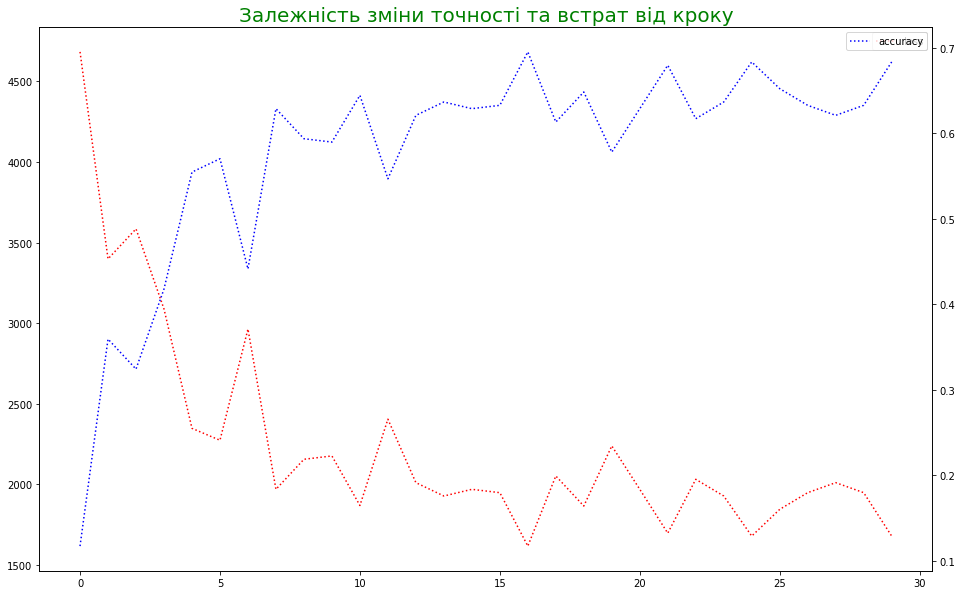

In [54]:
# Выведите графики зависимости изменения точности и потерь от шага
# Если все сделано правильно, то точность должна расти, а потери уменьшаться
fig, axs = plt.subplots(figsize=(16,10))
axs.plot(loss_history, 'r', label = 'loss', linestyle = ':')
axs.legend()

axs2 = axs.twinx()
axs2.plot(accuracy_history, 'b', label = 'accuracy', linestyle = ':')
plt.legend()

plt.title('Залежність зміни точності та встрат від кроку', fontsize = 20, color = 'g')
plt.show()

In [56]:
# Вычислите точность обученной нейросети

pred = neural_net(x_test)
print('Точність на тесті:%f'%accuracy(pred,y_test))

Точність на тесті:0.652100


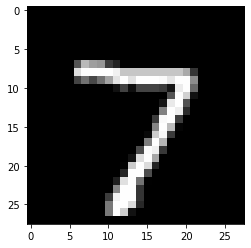

Model prediction:7


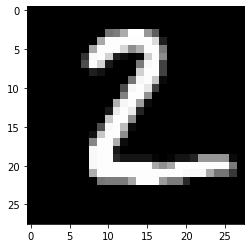

Model prediction:2


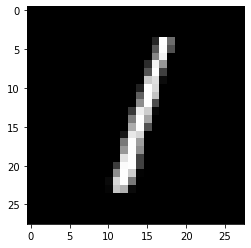

Model prediction:1


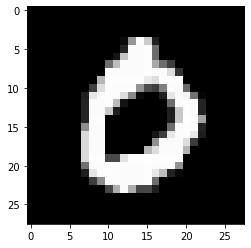

Model prediction:5


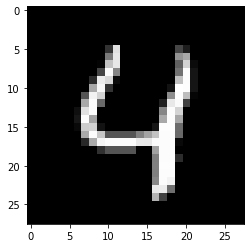

Model prediction:4


In [57]:
# Протестируем обученную нейросеть на 10 изображениях. Из тестовой выборки возьмите 5 
# случайных изображений и передайте их в нейронню сеть.
# Выведите изображение и выпишите рядом ответ нейросети.
# Сделайте вывод о том ошибается ли ваша нейронная сеть и если да, то как часто?


import matplotlib.pyplot as plt
n_images = 5
test_images = x_test[:n_images]
predictions = neural_net(test_images)

# display
for i in range(n_images):
    plt.imshow(np.reshape(test_images[i],[28,28]),cmap='gray')
    plt.show()
    print('Model prediction:%i'%np.argmax(predictions.numpy()[i]))